# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [ ]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

Downloading...
From: https://drive.google.com/uc?id=1Td42YImLQRtjgLV57ELkuOv0EO6FfNr9
To: /content/test.csv
100% 59.8M/59.8M [00:00<00:00, 144MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1GQtvtWNmMim5TCAUR0cxW-IapM7RjOxB
To: /content/training.csv
100% 238M/238M [00:02<00:00, 110MB/s]


In [ ]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

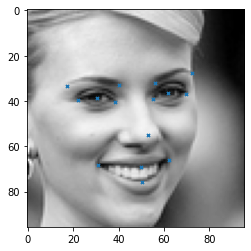

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


# Baseline model (you can skip this)

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)                1105950   
Total params: 1,143,518
Trainable params: 1,143,518
Non-trainable params: 0
____________________________________________

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 3s 141ms/step - loss: 0.3360 - val_loss: 0.1587
Epoch 2/50
11/11 [==============================] - 1s 84ms/step - loss: 0.1450 - val_loss: 0.1144
Epoch 3/50
11/11 [==============================] - 1s 81ms/step - loss: 0.1161 - val_loss: 0.0981
Epoch 4/50
11/11 [==============================] - 1s 85ms/step - loss: 0.0937 - val_loss: 0.0814
Epoch 5/50
11/11 [==============================] - 1s 83ms/step - loss: 0.0755 - val_loss: 0.0640
Epoch 6/50
11/11 [==============================] - 1s 80ms/step - loss: 0.0633 - val_loss: 0.0607
Epoch 7/50
11/11 [==============================] - 1s 83ms/step - loss: 0.0582 - val_loss: 0.0565
Epoch 8/50
11/11 [==============================] - 1s 84ms/step - loss: 0.0527 - val_loss: 0.0498
Epoch 9/50
11/11 [==============================] - 1s 84ms/step - loss: 0.0471 - val_loss: 0.0456
Epoch 10/50
11/11 [==============================] - 1s 81ms/step - loss: 0.0440 - val_loss: 0.0432
Epoch 11

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  2.0371044


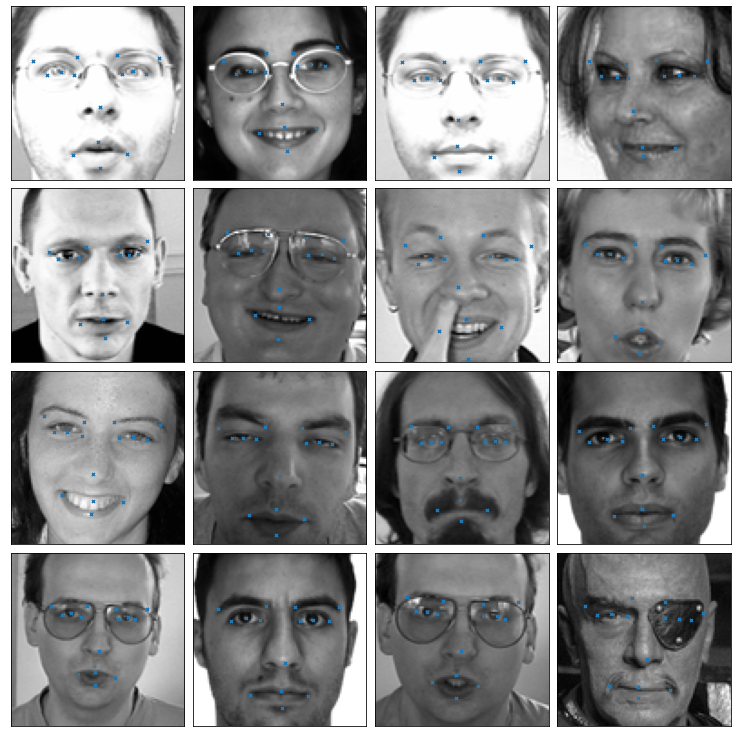

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

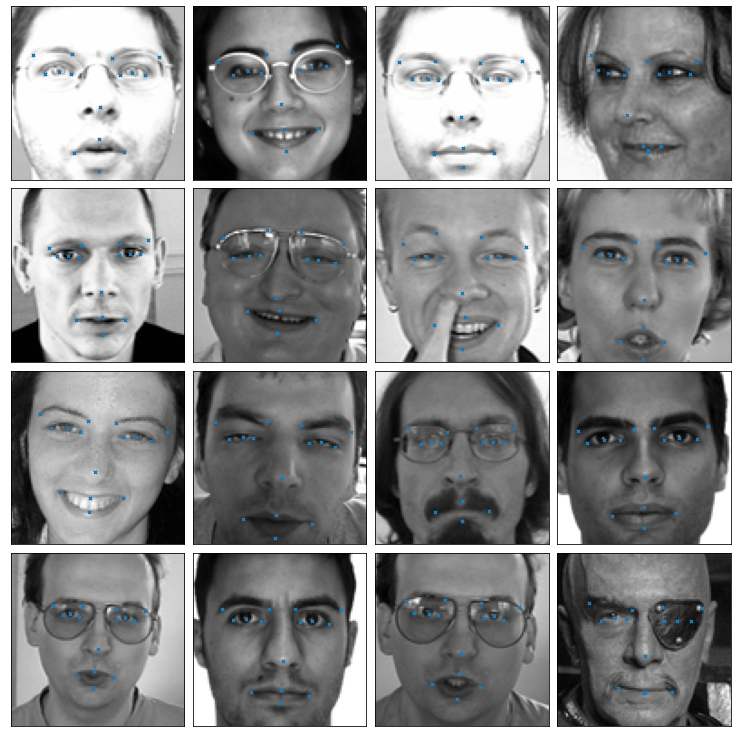

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Custom model

We will use the previous model as a baseline and will create a new one based on it.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# Best model so far: Conv2D(64) -> Conv2D(128) -> MaxPool2D -> Conv2D(64) -> MaxPool2D -> Conv2D(64) -> MaxPool2D -> Flatten -> Dropout(0.5) -> Dense(512) -> Dropout(0.2) -> Dense(output)
# Root mean squared pixel error: 1.57

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(128, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(128, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(256, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(256, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(256, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(256, kernel_size=(3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
batch_normalization_41 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 96, 96, 128)       73856     
_________________________________________________________________
batch_normalization_42 (Batc (None, 96, 96, 128)       512       
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 96, 96, 128)       0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 128)      

Let's define some functions to perform data augmentation. We want to perform the following operations:

- Horizontal flipping
- Increase of brightness
- Decrease of brightness

In [ ]:
def flip_images(images, keypoints):
    # Flip images
    flipped_images = np.copy(images)[:, :, ::-1, :]
    #flipped_key_points = np.zeros(points.shape)
    
    # Flip keypoints
    flipped_keypoints = np.copy(keypoints)

    for i in range(keypoints.shape[0]):
        # Flip only X coordinates of keypoints
        flipped_keypoints[i, 0::2] *=-1

        # Indices of x coordinates of the keypoints that have to be flipped
        flip_indices = [(0, 2), (1, 3), (4, 8), (5, 9), (6, 10), (7, 11), (12, 16), (13, 17), (14, 18), (15, 19), (22, 24), (23, 25)]

        # Flip left and right x coordinates
        for j, k in flip_indices:
            flipped_keypoints[i,j], flipped_keypoints[i,k] = flipped_keypoints[i,k], flipped_keypoints[i,j]
    
    return flipped_images, flipped_keypoints


def increase_brightness(images):
    return (images + 1) / 2


def decrease_brightness(images):
    return images * 0.5

In [ ]:
# Augment training data
x_flipped, y_flipped = flip_images(x_train, y_train)
x_bright = increase_brightness(x_train)
x_dark = decrease_brightness(x_train)

x_train_final = np.r_[x_train, x_flipped, x_bright, x_dark]
y_train_final = np.r_[y_train, y_flipped, y_train, y_train]

print(x_train_final.shape)

(5992, 96, 96, 1)


In [ ]:
batch_size = 64
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
  
model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train_final, y_train_final, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
85/85 [==============================] - 30s 341ms/step - loss: 1.0979 - val_loss: 0.2127
Epoch 2/50
85/85 [==============================] - 29s 338ms/step - loss: 0.2972 - val_loss: 0.1154
Epoch 3/50
85/85 [==============================] - 29s 342ms/step - loss: 0.1745 - val_loss: 0.1243
Epoch 4/50
85/85 [==============================] - 29s 342ms/step - loss: 0.1809 - val_loss: 0.1076
Epoch 5/50
85/85 [==============================] - 29s 342ms/step - loss: 0.1278 - val_loss: 0.1233
Epoch 6/50
85/85 [==============================] - 29s 342ms/step - loss: 0.1119 - val_loss: 0.0723
Epoch 7/50
85/85 [==============================] - 29s 342ms/step - loss: 0.0948 - val_loss: 0.0715
Epoch 8/50
85/85 [==============================] - 29s 343ms/step - loss: 0.0763 - val_loss: 0.0673
Epoch 9/50
85/85 [==============================] - 29s 342ms/step - loss: 0.0721 - val_loss: 0.0692
Epoch 10/50
85/85 [==============================] - 29s 343ms/step - loss: 0.0737 - val_lo

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.2223064


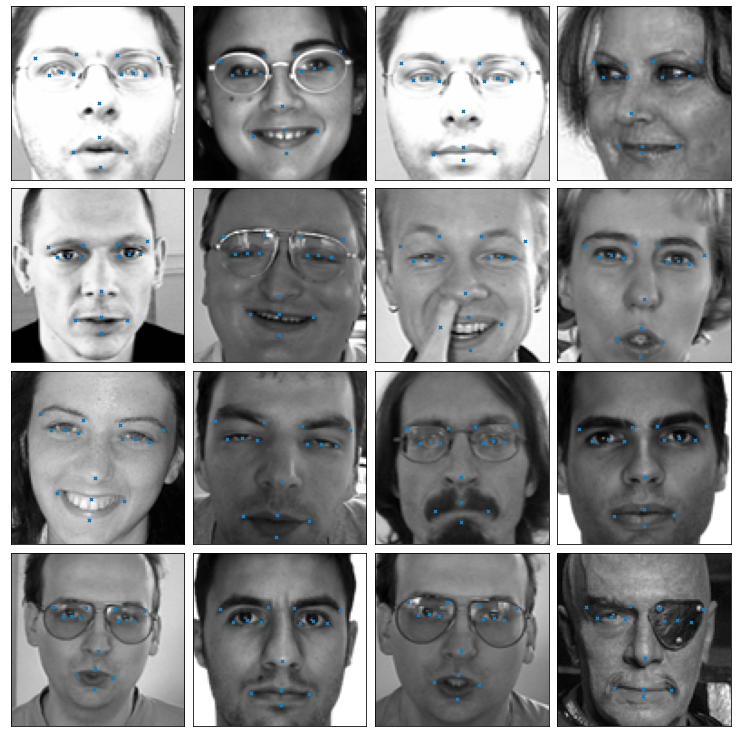

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

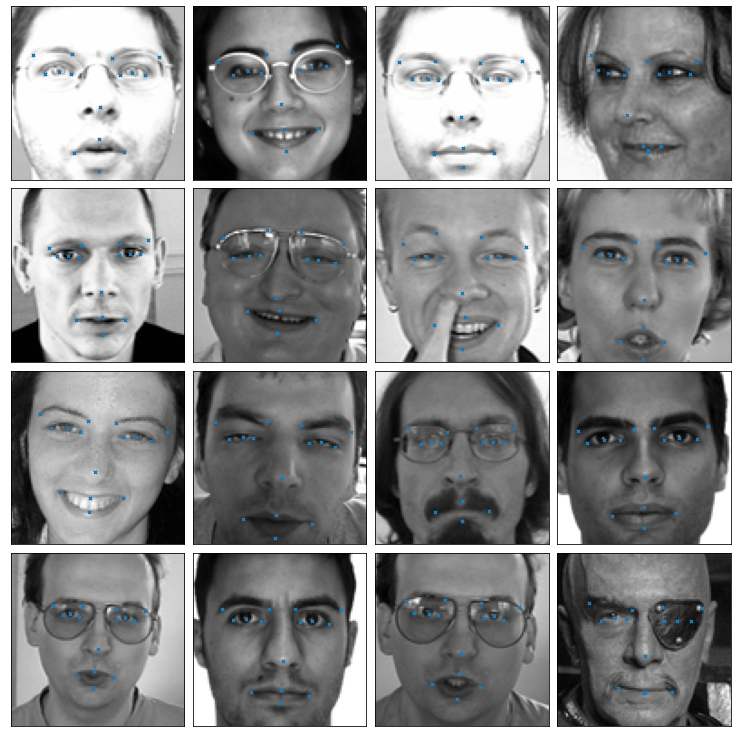

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.2223064.

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: First, I modified the baseline architecture by increasing the number of convolutional layers and their width, which made the CNN deeper and capable of extracting more information from the images. Also, I modified the regressor at the end of the network by adding one extra `Dense` layer of 512 neurons followed by a `Dropout` with parameter 0.5 between the flattening and the regression layers. I used the `Dropout` layer to prevent the network from overfitting since the vast majority of the parameters (approximately 4 million) could be found in the regressor. Additionally, I changed the activation function to `LeakyReLU` with parameter $\alpha = 0.1$ because it allowed me to get better results than using the standard `ReLU` as activation function. Finally, I reduced the reduced the **batch size** to 64 because I observed that the network performed better. All of these changes allowed me to reach a mean pixel error of 1.45 approximately.

Some additional experimentation that I performed during this stage was increasing the number of epochs and using early stopping, but it didn't make much of a difference, so I ended up discarding them and sticking to the 50 epochs of training.

Knowing that the results could be further improved, I decided to perform **data augmentation**. I declared some functions that allowed me to generate new images by horizontally flipping the original ones and increasing and increasing their brightness. When flipping the images, the $x$-axis values of some of the keypoints had to be swapped because the previous left part of the image became the current right part and vice versa. Increasing the brightness of the images implies computing the mean point between the current value of brightness of one pixel and the maximum brightness, which is 1. On the other hand, decreasing it implies halving the value of a pixel. Note that there are other operations that could be performed (rotations, random zooms, blurring, etc.), but some of them, such as rotations, are a bit harder to manually perform. Making this transformations, I ended up with 5992 training images, which is 4 times the initial number of images that we had.

Having now more samples, I modified once again the network's architecture, leaving untouched the regressor and changing the structure and depth of the the convolutional part. I created a convolutional block that consists of 2 convolutional layers with their respective `LeakyReLU` activations followed by a `MaxPooling2D` layer. I added four of these blocks together and plugged the regressor at the end of it. The number of filters per convolutional layer has been selected so that it follows an increasing fashion, limiting it to 256 filters (this is more of a technical decision, since a big part of the training was performed on my laptop due to Colab not allowing me to use an environment with GPU, and thus having some technical limitations because the VRAM of my GPU is not as big as the ones from Colab).

In order not to overfit, I tried to modify the convolutional blocks previously defined by adding some `Dropout` layers before the `MaxPooling2D` operations. However, I experimented some problems because the training loss spiked to a very high number in one epoch (probably due to noise). The network could never fully recover from this noisy epoch, and thus, the overall performance of the network was greatly impacted. Therefore, I decided to add `BatchNormalization` layers between the convolutional layers and the activation function. This final modification allowed the network to train better and get better results on the validation set afterwards.